In [1]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from classy import Class

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

## Derive mass functions

In [3]:
mfk = MassFunctionKink()

In [4]:
n_B_list = [0.9655, 3.]

In [5]:
CLASS_inst_list = []
for n_B in tqdm(n_B_list):
    CLASS_inst = mfk.get_CLASS_kink(k_B=10.,n_B=n_B)
    CLASS_inst_list.append(CLASS_inst)

100%|██████████| 2/2 [01:02<00:00, 31.22s/it]


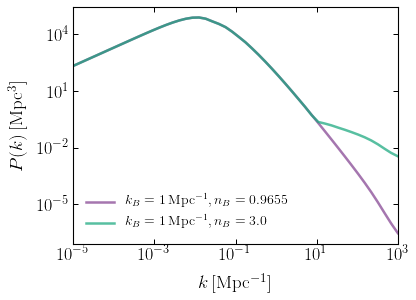

In [7]:
for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    k_ary = np.logspace(-5, np.log10(1000))
    pk_ary = np.array([CLASS_inst.pk_lin(k,0) for k in k_ary])
    plt.plot(k_ary, pk_ary, label="$k_B=1\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$k$\,[Mpc$^{-1}$]")
plt.ylabel("$P(k)$\,[Mpc$^{3}$]")
plt.xlim(min(k_ary), max(k_ary))
plt.legend(fontsize=14)

In [1251]:
[0.9665] + list(np.linspace(1, 6, 11))

[0.9665, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]

In [1252]:
def dn_dM_s(M_sc, CLASS_inst):
    R = (M_sc / (4 / 3. * np.pi * rho_m)) ** (1 / 3.)
    sigma = CLASS_inst.sigma(R / Mpc, 0) 
    sigma_log_deriv = np.abs(M_sc * derivative(lambda M: np.log(CLASS_inst.sigma((M / (4 / 3. * np.pi * rho_m)) ** (1 / 3.) / Mpc, 0)), x0=M_sc, dx=(0.9) * M_sc))
    return np.sqrt(2 / np.pi) * rho_m / M_sc ** 2 * delta_c / sigma * sigma_log_deriv * np.exp(-delta_c ** 2 / (2 * sigma ** 2))

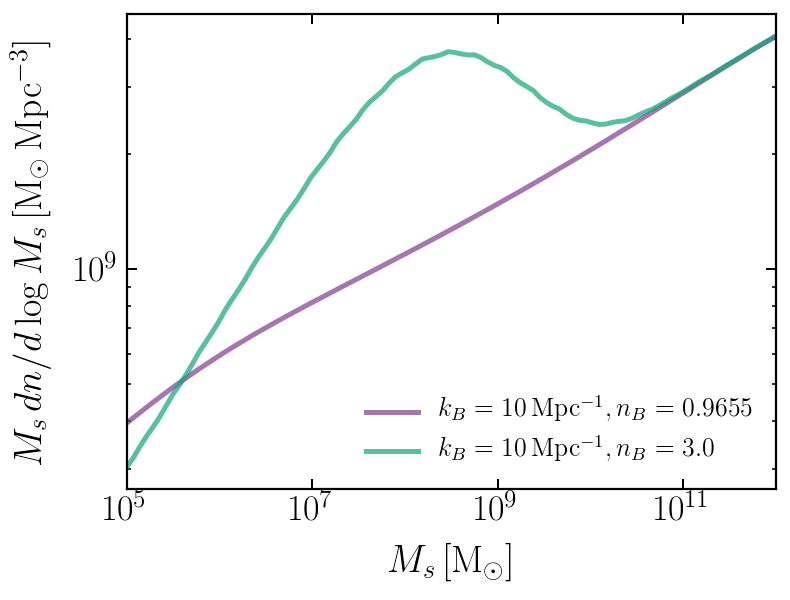

In [1253]:
M_ary = np.logspace(5, 12, 100) * M_s

for i_n_B, CLASS_inst in enumerate(CLASS_inst_list):
    plt.plot(M_ary / M_s, [M ** 2 * mfk.dn_dM_s(M, CLASS_inst) / (Mpc ** -3) / M_s for M in M_ary], label="$k_B=10\,$Mpc$^{-1}, n_B=" + str(n_B_list[i_n_B]) + "$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$M_s$\,[M$_\odot$]")
plt.ylabel("$M_s\, dn/d\log M_s\,[\mathrm{M_\odot}$\,Mpc$^{-3}$]")
plt.xlim(min(M_ary / M_s), max(M_ary / M_s))
plt.legend(fontsize=13)

## Calibration

In [74]:
N_calib = 150.
pref = N_calib / quad(lambda M: dn_dM_s(M, CLASS_inst_list[0]), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]

In [75]:
N_calib_new = pref * quad(lambda M: dn_dM_s(M, CLASS_inst_list[3]), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-2)[0]

In [76]:
M_sc_calib = 1e11 * M_s
pspecpop = PowerSpectraPopulations(l_max=2000, CLASS_inst=CLASS_inst_list[3], fudge_factor_rho_s=1.)
rho_s_new = pspecpop.get_rs_rhos_NFW(M_sc_calib)[1]

In [77]:
from scipy.optimize import fsolve
M200 = 10 ** fsolve(lambda M200: np.log10(M_sc_calib / M_s) - np.log10(pspecpop.get_M_sc(10 ** M200 * M_s) / M_s), 9.)[0] * M_s
pspecpop = PowerSpectraPopulations(l_max=2000)
rho_s_old = pspecpop.get_rs_rhos_NFW(M200)[1]

In [78]:
fudge_factor_rho_s = rho_s_old / rho_s_new

## Sensitivity

In [432]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

In [86]:
pspecpop = PowerSpectraPopulations(l_max=2000)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(pspecpop.rho_M_SI, M_min=1e4*M_s, M_max=0.01*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=150, alpha=-1.9)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu_notidal = pspecpop.get_C_l_total_ary();

100%|██████████| 50/50 [01:26<00:00,  1.71s/it]


In [90]:
M_ary = np.logspace(4, 12) * M_s
dndM_ary = np.array([dn_dM_s(M, CLASS_inst_list[0]) for M in M_ary])

dndM_interp = interp1d(np.log10(M_ary), np.log10(dndM_ary))

def dndM(M):
    return 10 ** dndM_interp(np.log10(M))

pspecpop = PowerSpectraPopulations(l_max=2000, CLASS_inst=CLASS_inst_list[0], fudge_factor_rho_s=fudge_factor_rho_s)

pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
pspecpop.set_mass_distribution(dndM, M_min=1e4*M_s, M_max=0.01*1.1e12*M_s, 
                               M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=N_calib_new)
pspecpop.set_subhalo_properties(pspecpop.c200_Moline)

C_l_mu_new = pspecpop.get_C_l_total_ary()

100%|██████████| 50/50 [16:47<00:00, 19.23s/it]


In [91]:
alpha_plot = 0.8
lw_plot = 2.5
colors_plot = ['dodgerblue', 'orange', 'mediumorchid']

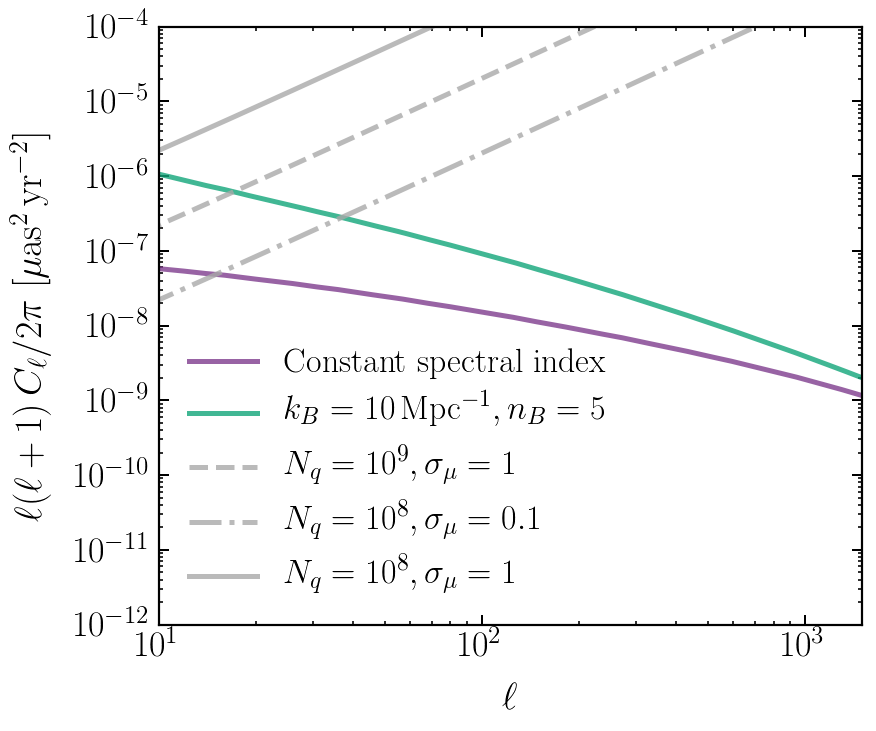

In [92]:
mpl.rcParams['figure.figsize'] = 6.3, 5.5

fig, ax = plt.subplots(1, 1)

c2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_notidal, label="Constant spectral index", alpha=alpha_plot, lw=lw_plot)
c3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_new, label="$k_B=10\,$Mpc$^{-1}, n_B=5$", alpha=alpha_plot, lw=lw_plot)

sigma_mu = 1
N_q = 1e9

l1 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = .1
N_q = 1e8

l2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 1
N_q = 1e8

l3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

plt.legend()

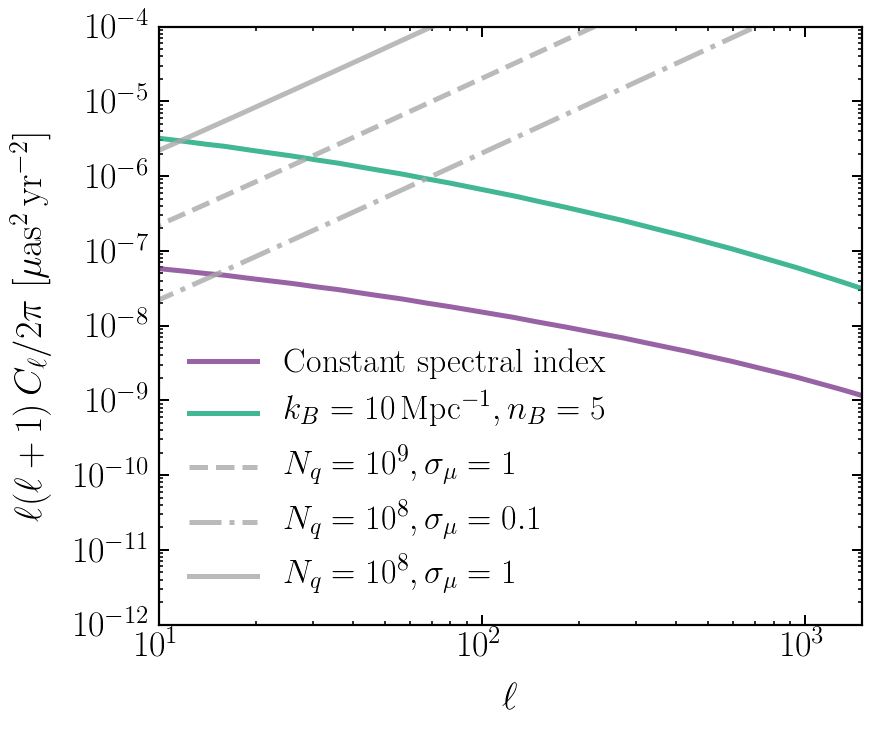

In [83]:
mpl.rcParams['figure.figsize'] = 6.3, 5.5

fig, ax = plt.subplots(1, 1)

c2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_notidal, label="Constant spectral index", alpha=alpha_plot, lw=lw_plot)
c3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_new, label="$k_B=10\,$Mpc$^{-1}, n_B=5$", alpha=alpha_plot, lw=lw_plot)

sigma_mu = 1
N_q = 1e9

l1 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = .1
N_q = 1e8

l2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 1
N_q = 1e8

l3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

plt.legend()

In [84]:
# Test

sigma_mu = 1.
sigma_alpha = .1
N_q = 1e8

fDM_base = 1
dfDM_base = 0.1

Cl_ary_fid = C_l_mu_new*fDM_base

p = C_l_mu_new*(fDM_base + dfDM_base)
m = C_l_mu_new*(fDM_base - dfDM_base)

fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                None, None, '$\\f_\mathrm{DM}$' )

parameters = [Cl_ary_fid, None, pspecpop.l_min, pspecpop.l_max, fDM]
observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

fshr = FisherForecast(parameters, observation)
lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
print(lim)
baseline_sig = fDM_base/fshr.pars_vary[0].sigma
print(baseline_sig)

0.30627454017309974
5.354672964566717


## Analyze cluster runs

(1e-12, 0.0001)

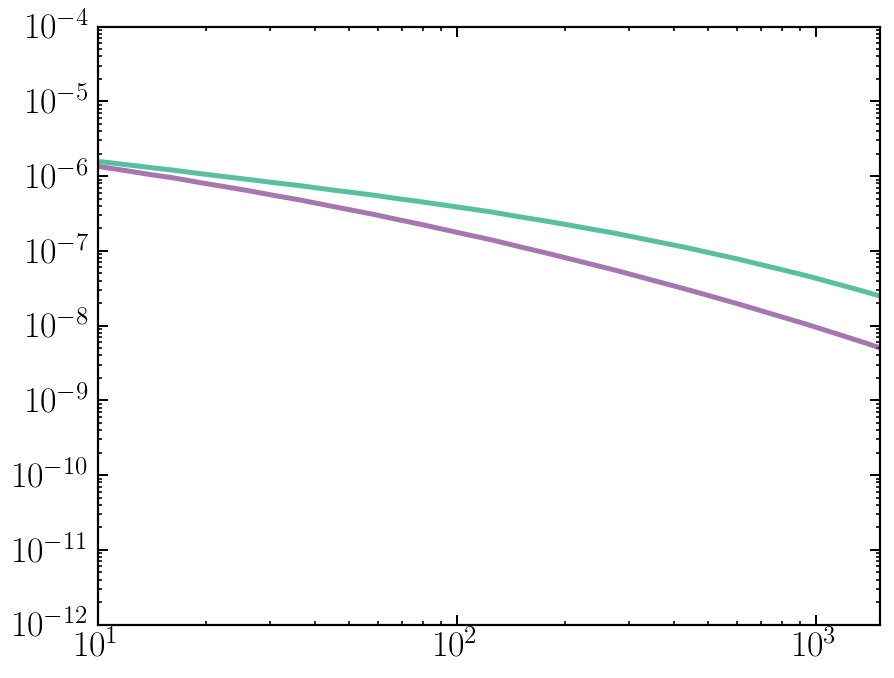

In [63]:
l_ary = np.arange(1, 2000)
Cl_ary = np.load("../cluster/cluster_out/1.0_0.9665.npz")['C_l_mu_new']
plt.plot(l_ary, (1/(2*np.pi))*l_ary*(l_ary + 1)*Cl_ary)
Cl_ary = np.load("../cluster/cluster_out/100.0_5.0.npz")['C_l_mu_new']
plt.plot(l_ary, (1/(2*np.pi))*l_ary*(l_ary + 1)*Cl_ary)
plt.xscale("log")
plt.yscale("log")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

In [ ]:
mpl.rcParams['figure.figsize'] = 6.3, 5.5

fig, ax = plt.subplots(1, 1)

c2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_notidal, label="Constant spectral index", alpha=alpha_plot, lw=lw_plot)
c3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*C_l_mu_new, label="$k_B=10\,$Mpc$^{-1}, n_B=5$", alpha=alpha_plot, lw=lw_plot)

sigma_mu = 1
N_q = 1e9

l1 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^9, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='--')

sigma_mu = .1
N_q = 1e8

l2 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=0.1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-.')

sigma_mu = 1
N_q = 1e8

l3 = ax.plot(pspecpop.l_ary, (1/(2*np.pi))*pspecpop.l_ary*(pspecpop.l_ary + 1)*np.ones_like(pspecpop.l_ary)*4*np.pi*sigma_mu**2/N_q, label="$N_q = 10^8, \sigma_\mu=1$", alpha=alpha_plot, lw=lw_plot, color='darkgrey', ls='-')

plt.yscale("log")
plt.xscale("log")

plt.xlabel("$\ell$")
plt.ylabel("$\ell(\ell+1)\,C_\ell/2\pi$ [$\mu$as$^2$\,yr$^{-2}$]")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

plt.legend()

In [40]:
def get_sens(Cl_ary, sigma_mu=1., N_q=1e8):

    fDM_base = 1
    dfDM_base = 0.1

    Cl_ary_fid = Cl_ary*fDM_base

    p = Cl_ary*(fDM_base + dfDM_base)
    m = Cl_ary*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    None, None, '$\\f_\mathrm{DM}$' )

    parameters = [Cl_ary_fid, None, 1, 2000, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    baseline_sig = fDM_base/fshr.pars_vary[0].sigma
    return lim, baseline_sig

In [41]:
get_sens(Cl_ary)

(0.5032387386558064, 3.258890610012615)

In [48]:
n_B_ary = (np.linspace(1, 6, 11))
k_B_ary = np.logspace(np.log10(1), np.log10(100), 11)

sens_ary = np.zeros((len(n_B_ary), len(k_B_ary)))

for i_n_B, n_B in enumerate(tqdm(n_B_ary)):
    for i_k_B, k_B in enumerate(k_B_ary):
        Cl_ary = np.load("../cluster/cluster_out/" + str(k_B) + "_" + str(n_B) + ".npz")['C_l_mu_new']
        sens_ary[i_n_B, i_k_B] = get_sens(Cl_ary)[1]

11it [00:14,  1.30s/it]


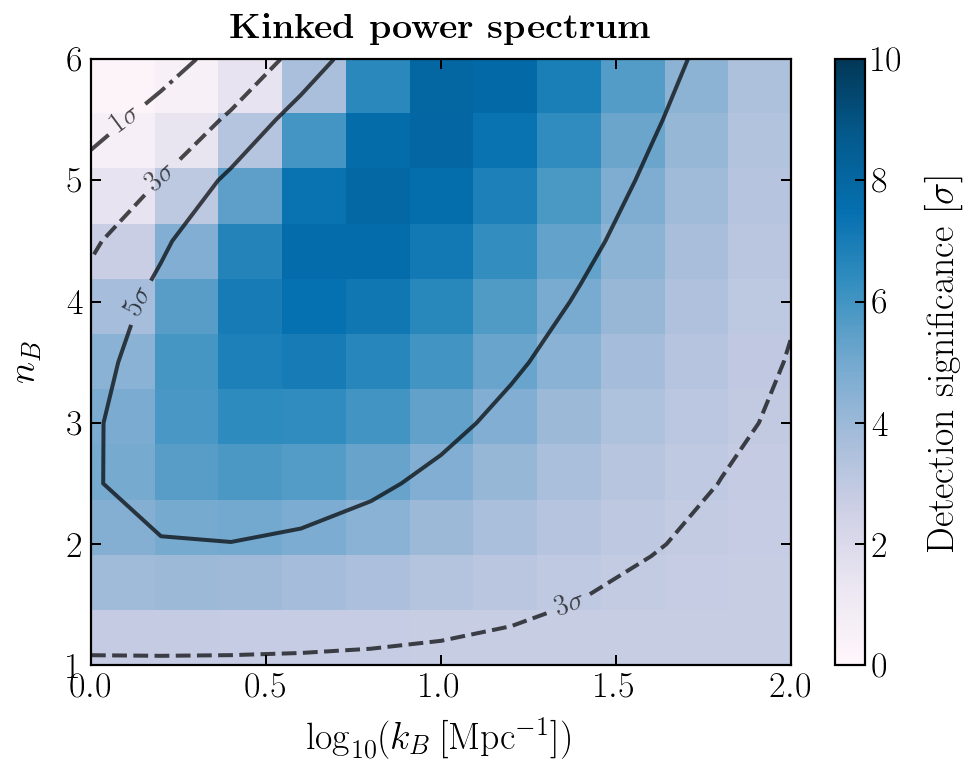

In [56]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
X, Y = np.meshgrid(np.log10(k_B_ary), n_B_ary)

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sens_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sens_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[0,2,1,6], vmin=0, vmax=10)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
ax.set_ylabel("$n_B$")
ax.set_title('\\textbf{Kinked power spectrum}', fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
# plt.savefig(plots_dir + "LCDM_disc.pdf")

In [99]:
c = 10.
(200. / 3.) * c ** 3 / (np.log(1 + c) - c / (1 + c))

44778.661516447675

## New calibration

In [9]:
import random, string

def randomword(length):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(length))


In [18]:
from scipy.interpolate import interp1d

In [233]:
k_ary = np.logspace(-5, 3., 10000)
Pk_ary_base = np.array([CLASS_inst_list[0].pk_lin(k,0) for k in k_ary])
Pk_ary = np.array([CLASS_inst_list[1].pk_lin(k,0) for k in k_ary])

log10_interp_ary = np.linspace(-5, 3, 10000)
log10_P_interp = interp1d(np.log10(k_ary * h), np.log10(Pk_ary_base / h ** 3), bounds_error=False, fill_value='extrapolate')
log10_P_interp_ary = (log10_P_interp)(log10_interp_ary)
np.savetxt("/Users/smsharma/Desktop/pk_base.dat", np.transpose([log10_k_ary_interp, log10_P_interp_ary]),
           delimiter='\t')
# np.savetxt("/Users/smsharma/Desktop/pk.dat", np.transpose([np.log10(k_ary * h), np.log10(Pk_ary / h ** 3)]),
#            delimiter='\t')



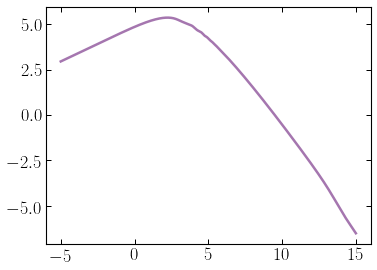

In [232]:
plt.plot(log10_k_ary_interp, log10_P_interp_ary)


In [219]:
# sys.path.append('/Users/smsharma/heptools/colossus/')

# from colossus.cosmology import cosmology
# from colossus.lss import mass_function

# cosmo = cosmology.setCosmology('planck18')
# # cosmo.matterPowerSpectrum = lambda k: k ** 5
# # cosmo.matterPowerSpectrum(10, path="/Users/smsharma/Desktop/pk.dat", model='custom')
# cosmology.setCurrent(cosmo)
# # cosmo.sigma(1, 0, ps_args={'model': 'custom', 'path':"/Users/smsharma/Desktop/pk.dat"})

# # M_ary = np.logspace(5,12)
# # # mf1 = mass_function.massFunction(M_ary, 0.0, mdef = 'fof', model = 'press74', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk.dat"})
# # mf1 = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk.dat"})

# # plt.plot(M_ary, M_ary * mf1)

# # cosmo = cosmology.setCosmology('planck18')
# # cosmo.matterPowerSpectrum(10)
# # cosmology.setCurrent(cosmo)

# # mf2 = mass_function.massFunction(M_ary, 0.0, mdef = 'fof', model = 'press74', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk_base.dat"})
# mf2 = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk_base.dat"})
# plt.plot(M_ary, M_ary * mf2)

# plt.xscale("log")
# plt.yscale("log")

## Densities

In [220]:
from classy import Class

common_settings = {  # Background parameters
    'H0': 67.32117,
    'omega_b': 0.02238280,
    'N_ur': 2.03066666667,
    'omega_cdm': 0.1201075,
    'N_ncdm': 1,
    'omega_ncdm': 0.0006451439,
    'YHe': 0.2454006,
    'tau_reio': 0.05430842,
    'modes': 's',

    # Output settings
    'output': 'mPk'
}

CLASS_inst = Class()
CLASS_inst.set(common_settings)
CLASS_inst.compute()


In [337]:
from scipy.special import erfc

def delta_sc(z):
    return delta_c / D(z)

def D(z):
    return cosmo.growthFactor(z)

def sigma(M, z=0):
    return cosmo.sigma((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.) / Mpc, z)

def sigma_mod(M, z=0):
    return cosmo.sigma((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.) / Mpc, z, ps_args={'model': randomword(5), 'path':"/Users/smsharma/Desktop/pk_base.dat"})

def sigma_CLASS(M, z=0):
    return CLASS_inst_list[0].sigma((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.) / Mpc, z)

def W(k, R):
    return 3 * (k * R) ** -3 * (np.sin(k * R) - k * R * np.cos(k * R))

def sigma_hand(R):
    sigma2 = quad(lambda k: (k ** 3 / (2 * np.pi ** 2)) * 1 / k * 10 ** log10_P_interp(np.log10(k / (h * Mpc ** -1))) * Mpc ** 3 / h ** 3 * np.abs(W(k, R)) ** 2, 10 * Mpc ** -1, 1e7 * Mpc ** -1, epsabs=0, epsrel=1e-6)[0]
    return np.sqrt(sigma2)


def integrand_hand(k, R):
    return (k ** 3 / (2 * np.pi ** 2)) * 1 / k * 10 ** log10_P_interp(np.log10(k / (h * Mpc ** -1))) * Mpc ** 3 / h ** 3 * np.abs(W(k, R)) ** 2

def integrand_hand(k, R):
    return (k ** 3 / (2 * np.pi ** 2)) * 1 / k * cosmo.matterPowerSpectrum(k / (Mpc ** -1 * h), 0) * Mpc ** 3 / h ** 3 * np.abs(W(k, R)) ** 2

def sigma_trapz(R):
    logk_integ_ary = np.linspace(-6 , 15, 1000)
    measure = logk_integ_ary[1] - logk_integ_ary[0]
    integ = 0
    for logk in logk_integ_ary:
        k = 10 ** logk * Mpc ** -1
        integ += k * integrand_hand(k, R)
    integ *= measure
    return np.sqrt(integ)

In [338]:
sigma_trapz(0.001 * Mpc)

8.531870627270392

In [339]:
cosmo.sigma(0.001, 0)

12.329442697232926

In [340]:
M = 1e6 * M_s
sigma_hand((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.))

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


9.424892593307272

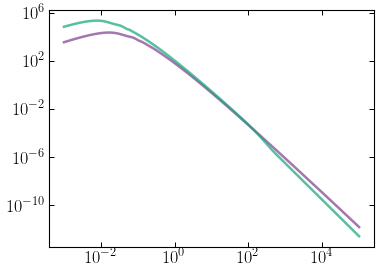

In [358]:
k_ary = np.logspace(-3, 5, 100) * Mpc** -1 * h
plt.plot(k_ary / (Mpc** -1 * h), cosmo.matterPowerSpectrum(k_ary / (Mpc** -1 * h), 0))
plt.plot(k_ary / (Mpc** -1 * h), [10 ** log10_P_interp(np.log10(k / (Mpc ** -1 * h))) for k in k_ary])
plt.xscale("log")
plt.yscale("log")

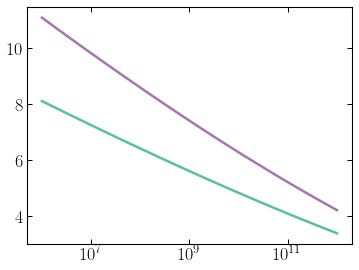

In [347]:
M_ary = np.logspace(6, 12, 20) * M_s

plt.plot(M_ary / M_s, [sigma(M) for M in M_ary])
# plt.plot(M_ary / M_s, [sigma_CLASS(M) for M in M_ary])
# plt.plot(M_ary / M_s, [sigma_hand((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.)) for M in M_ary])
plt.plot(M_ary / M_s, np.array([sigma_trapz((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.) * h) for M in M_ary]))

# plt.plot(M_ary / M_s, [CLASS_inst.sigma((M / (4 / 3. * np.pi * 200 * rho_c)) ** (1 / 3.) / Mpc, 0) for M in M_ary])

# plt.plot(M_ary / M_s, [sigma_mod(M) for M in M_ary])

plt.xscale("log")

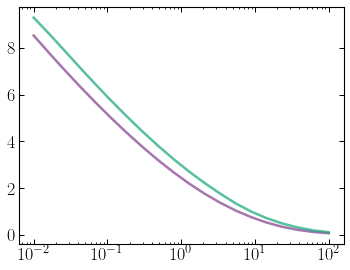

In [288]:
R_ary = np.logspace(-2, 2, 20)

plt.plot(R_ary, [cosmo.sigma(R, 0) for R in R_ary])
plt.plot(R_ary, [CLASS_inst_list[0].sigma(R, 0) for R in R_ary])
# plt.plot(M_ary / M_s, [sigma_mod(M) for M in M_ary])

plt.xscale("log")
# plt.yscale("log")

In [1305]:
# z_ary = np.logspace(-3, 11, 100)
# plt.plot(CLASS_inst_list[0].get_background()['z'], CLASS_inst_list[0].get_background()['gr.fac. D'])
# plt.plot(z_ary, [D(z) for z in z_ary])

# plt.plot()
# plt.xscale("log")
# plt.yscale("log")

In [1306]:
def D(z):
    '''
    Linear growth factor normalized to z=0. The mathematics follows from
    Equation 5 of arxiv.org/pdf/1309.5385.pdf
    Inputs:
    z: redshift (single value);
    Output:
    Linear growth factor
    '''

    gamma = 0.55
    f = lambda z: 1/(1+z)*(Planck15.Om(z))**0.55

    growth_factor = np.exp(-quad(f, 0, z, epsabs=0, epsrel=1e-10)[0])

    return growth_factor


In [44]:
from scipy.optimize import fsolve, brentq

In [46]:
from scipy.optimize import minimize

In [47]:
f = 0.02
C = 650.

n_iter_max = 100

z_coll_ary = np.zeros(n_iter_max)
c200_ary = np.zeros(n_iter_max)

z_coll_ary[0] = 0.1
c200_ary[0] = 10.

def c200_zcoll(M200):

    for i in range(1, n_iter_max):
        opt = minimize(lambda z_coll: np.abs(erfc((delta_sc(z_coll) - delta_sc(0)) / (np.sqrt(2 * (sigma(f * M200) ** 2 - sigma(M200) ** 2)))) - ((-1 + np.log(4)) / 2. / (-1 + 1 / (1 + c200_ary[i - 1]) + np.log(1 + c200_ary[i - 1])))), [10.], bounds=[[0.1,2000.]], method='SLSQP')
        z_coll_ary[i] = opt.x
        c200_ary[i] = minimize(lambda c200: np.abs(C * (Planck15.H(z_coll_ary[i]).value / Planck15.H0.value) ** 2 - (200. / 3. / 4. * c200 ** 3 / (np.log(1 + c200) - c200 / (1 + c200)))), [10.], bounds=[[1.,1e5]], method='SLSQP').x

        z_err = np.abs((z_coll_ary[i] - z_coll_ary[i - 1]) / z_coll_ary[i - 1])
        c200_err = np.abs((c200_ary[i] - c200_ary[i - 1]) / c200_ary[i - 1])

        if z_err < 0.01 and  c200_err < 0.01: break

    return c200_ary[i], z_coll_ary[i]

In [50]:
c200_zcoll(1e8 * M_s)

(34.74691526256893, 10.0)

In [51]:
M_ary = np.logspace(6, 15, 20) * M_s
c200_ary = [c200_zcoll(M) for M in tqdm(M_ary)]

100%|██████████| 20/20 [03:17<00:00,  9.53s/it]


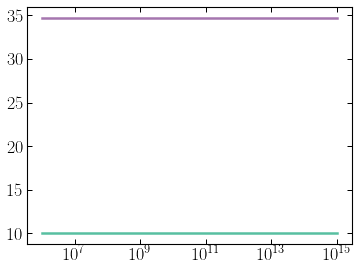

In [52]:
plt.plot(M_ary / M_s, c200_ary)
plt.xscale("log")

## $\sigma$ checks